# Курс «Машинное обучение в бизнесе»

## Урок 4. Кейс 1. Построение и оценка модели

### Домашнее задание к уроку 4

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import itertools

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 
import os

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

import warnings

#### Задание 1

Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [2]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [4]:
data.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000
mean,32079.773047,2009.801340,6.435979,15.722681,2.481241,180.459835,26.218643,2.999168,11.501101,0.027233,0.027075,0.027240
std,6464.167501,4.791885,3.438982,8.801258,1.114448,105.138073,15.019836,1.999572,6.921927,0.162763,0.162303,0.162783
min,14544.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27573.000000,2006.000000,3.000000,8.000000,1.000000,90.000000,13.000000,1.000000,6.000000,0.000000,0.000000,0.000000
50%,31421.000000,2010.000000,6.000000,16.000000,2.000000,179.000000,26.000000,3.000000,12.000000,0.000000,0.000000,0.000000
75%,35648.750000,2014.000000,9.000000,23.000000,3.000000,271.000000,39.000000,5.000000,18.000000,0.000000,0.000000,0.000000
max,62009.000000,2018.000000,12.000000,31.000000,4.000000,366.000000,53.000000,6.000000,23.000000,1.000000,1.000000,1.000000


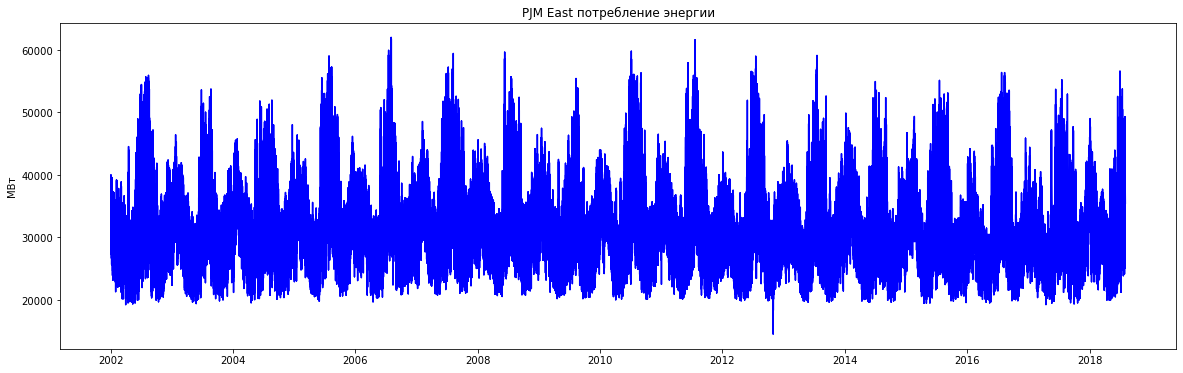

In [5]:
plt.figure(figsize =(20,6))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [6]:
data_w = data['PJME_MW'].resample('W').mean()

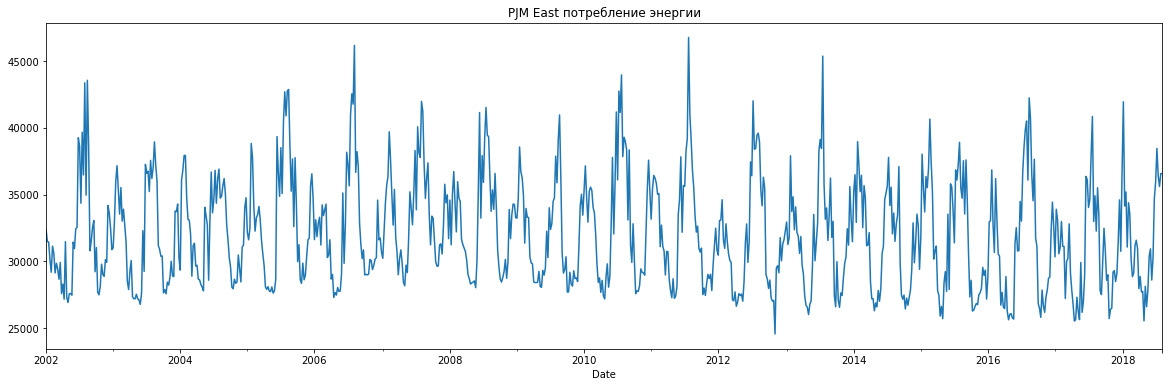

In [7]:
data_w.plot(figsize=(20, 6), title='PJM East потребление энергии')

#### Задание 2

Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков.

In [8]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
data_exp_1 = exponential_smoothing(data['PJME_MW'], 0.05)

In [11]:
b_s = pd.DataFrame(data = data[['PJME_MW']])

In [12]:
data_exp_1 = pd.DataFrame(data = data_exp_1, index = b_s.index)

In [13]:
df_end= pd.DataFrame(data_exp_1)

In [14]:
scl = StandardScaler()
scly = StandardScaler()

# сделаем примеры и модель 
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train_b, test_b = split_data_b(df_end, '10-10-2014')

X_train_b = train_b.iloc[:-1,:]
y_train_b = train_b[df_end.columns[0]].values[1:]
X_test_b = test_b.iloc[:-1,:]
y_test_b = test_b[df_end.columns[0]].values[1:]

In [15]:
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit(X_train_b, y_train_b) 
X_test_pred_gb = model_gb.predict(X_test_b)

In [16]:
h = 4
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df_end.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df_end.columns[0]].values[h:]

model_gb.fit(X_train_b, y_train_b) 
X_test_pred_gb = model_gb.predict(X_test_b)

In [17]:
warnings.filterwarnings("ignore")
for i in range(4):
    X_test_b.loc[len(X_test_b)] = model_gb.predict(X_test_b[-1:])

In [40]:
print('Значение предсказания четвертой точки от текущей:', X_test_b[-1:])

Значение предсказания четвертой точки от текущей:                   0
Date               
33415  39576.746329


Ничего не понял. Сделал как понял.

#### Задание 3

Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

In [43]:
print('Значение предсказания первой точки от текущей:', X_test_b[-4:-3])

Значение предсказания первой точки от текущей:                   0
Date               
33412  40532.911571


#### Задание 4

Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

In [20]:
# Ничего не понял. Вернусь к этому позже.

#### Задание 5

Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек).

In [21]:
# Ничего не понял. Вернусь к этому позже.

#### Задание 6

Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [22]:
# Ничего не понял. Вернусь к этому позже.